In [1]:
# ==========================================
# 1. Setup do Ambiente
# ==========================================
from google.colab import drive
import sys
import os

# Montar Drive (opcional, se estiver salvando lá)
drive.mount('/content/drive')

# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/mlp_treaning

# Instalar dependências específicas
!pip install -q xgboost pykan

# Adicionar diretório atual ao path para importações funcionarem
sys.path.append('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'telecom-churn-project' already exists and is not an empty directory.
/content/telecom-churn-project
Already on 'feature/mlp_treaning'
Your branch is up to date with 'origin/feature/mlp_treaning'.


In [2]:
# ---------------------------------------------------------
# CORREÇÃO PARA AUTORELOAD NO PYTHON 3.12 (Google Colab)
# Executar na primeira célula do notebook
# ---------------------------------------------------------
import sys
import importlib

# O Python 3.12 removeu o 'imp', mas o autoreload antigo precisa dele.
# Vamos criar um "falso" imp apontando para o importlib.
if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

# Agora sim, carregamos a extensão mágica
%load_ext autoreload
%autoreload 2

In [3]:
# # 1. Baixa as informações mais recentes do GitHub (sem tentar mesclar ainda)
!git fetch origin

# # 2. Reseta o estado atual do Colab para ficar IDÊNTICO ao do GitHub
!git reset --hard origin/feature/mlp_treaning

HEAD is now at 89a0637 feat: add notebook mlp


In [4]:
# ==========================================
# Célula para Baixar Dados (Kaggle)
# ==========================================
import kagglehub
import shutil
import os

print("⬇️ Baixando dataset do Kaggle...")
# Baixa a versão mais recente
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")

# Caminhos de destino
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"
dest_path = os.path.join(dest_dir, dest_file)

# Criar pasta se não existir
os.makedirs(dest_dir, exist_ok=True)

# O arquivo original geralmente vem com este nome:
source_file = os.path.join(path, "customer_churn_telecom_services.csv")

# Mover e renomear
if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...
Using Colab cache for faster access to the 'customers-churned-in-telecom-services' dataset.
📂 Dataset baixado em: /kaggle/input/customers-churned-in-telecom-services
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


In [5]:
# ==========================================
# 2. Executar Pipeline de Dados
# ==========================================
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [6]:
# ==========================================
# 3. Imports e Carregamento dos Dados
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Importando SUAS classes e funções
from models.mlp_model import MLPModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

# Carregar dados processados (gerados pelo prepare_data.py)
DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

# Helper simples para exibir métricas no notebook
def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


🚀 Treinando MLP...
--- MLP (Teste) ---
KS:        0.4986 (Threshold: 0.39)
AUROC:     0.8277
F1 Score:  0.5985


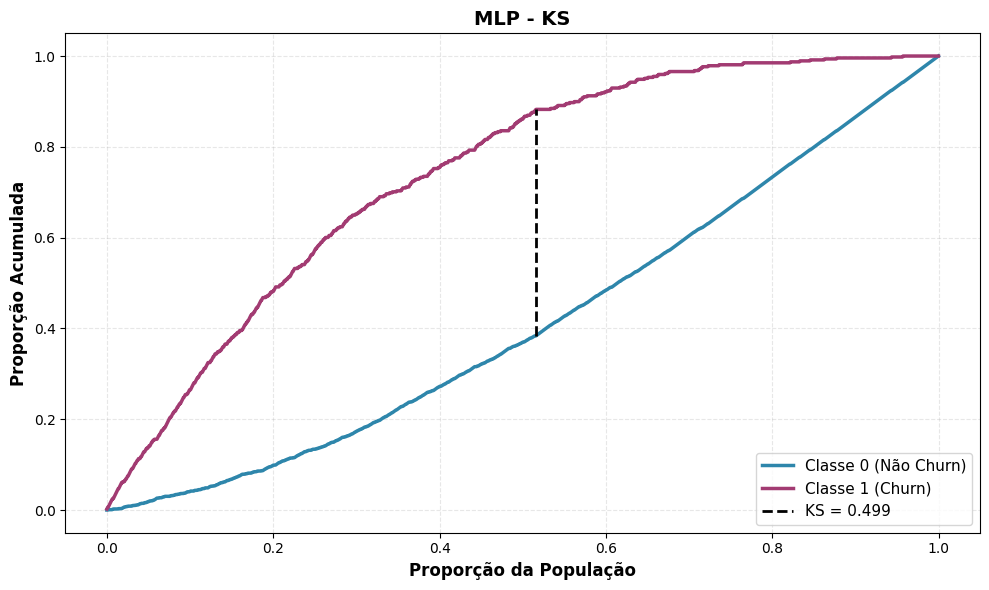

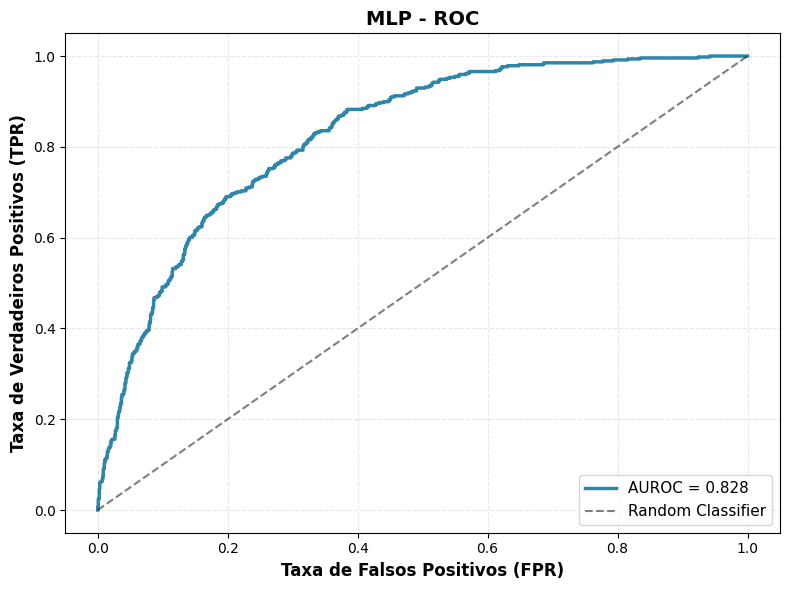

In [7]:
# ============================
# 4. Experimento: MLP (Sklearn)
# ============================
print("🚀 Treinando MLP...")

mlp = MLPModel(name="MLP_Baseline")
mlp.build(hidden_layer_sizes=(10,), activation="relu", learning_rate_init=0.001, max_iter=10000)
mlp.train(X_train, y_train, X_val, y_val)

# Avaliação no Teste
y_pred_mlp = mlp.predict_proba(X_test)[:, 1]
metrics_mlp = calculate_all_metrics(y_test, y_pred_mlp)

print_metrics("MLP (Teste)", metrics_mlp)

# Visualizações
plot_ks_statistic(y_test, y_pred_mlp, title="MLP - KS")
plot_roc_curve(y_test, y_pred_mlp, title="MLP - ROC")


**Otimização com Optuna**

In [8]:
!pip install optuna

In [9]:
import optuna

def objective(trial):
    # 1. Sugerir hiperparâmetros (Search Space do Slide 27)

    # Topologia: 1 ou 2 camadas, começando pequeno (Slide 24/27)
    n_layers = trial.suggest_int('n_layers', 1, 2)
    layers = []
    for i in range(n_layers):
        # Neurônios entre 10 e 100
        units = trial.suggest_int(f'n_units_l{i}', 10, 100, step=10)
        layers.append(units)

    hidden_layer_sizes = tuple(layers)

    # Outros parâmetros
    activation = trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2) # Regularização

    # 2. Instanciar e Treinar Modelo
    # Usamos os parâmetros estáticos exigidos (Max iter 10k, Patience 20)
    model = MLPModel(name=f"Trial_{trial.number}")

    model.build(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        max_iter=10000,        # Slide 24
        early_stopping=True,   # Slide 24
        n_iter_no_change=20    # Slide 24 (Patience)
    )

    try:
        # Treina e pega o histórico
        history = model.train(X_train, y_train, X_val, y_val)

        # Otimizamos pelo LogLoss da validação (quanto menor, melhor)
        return history['val_logloss']

    except Exception as e:
        # Caso o modelo não convirja ou dê erro (ex: explosão de gradiente)
        print(f"Erro no trial: {e}")
        return float('inf')

# Criar o estudo
study = optuna.create_study(direction='minimize')
print("🚀 Iniciando Otimização com Optuna...")
study.optimize(objective, n_trials=20) # Comece com 20 ou 50 trials

print("\n✅ Melhores parâmetros encontrados:")
print(study.best_params)


[I 2025-12-17 02:19:15,336] A new study created in memory with name: no-name-e497e224-17fd-4bff-834f-49dedcdae318
/tmp/ipython-input-1135910548.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
/tmp/ipython-input-1135910548.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2) # Regularização


🚀 Iniciando Otimização com Optuna...


[I 2025-12-17 02:19:17,642] Trial 0 finished with value: 0.9487500218487865 and parameters: {'n_layers': 1, 'n_units_l0': 40, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.08129000392567903, 'alpha': 0.00034249826192985324}. Best is trial 0 with value: 0.9487500218487865.
/tmp/ipython-input-1135910548.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)
/tmp/ipython-input-1135910548.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2) # Regularização
[I 2025-12-17 02:19:24,397] Trial 1 finished with value: 0.631571197431


✅ Melhores parâmetros encontrados:
{'n_layers': 2, 'n_units_l0': 70, 'n_units_l1': 90, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.0005859073413679145, 'alpha': 3.568318312564264e-05}


**Treinar e Avaliar o Modelo Optuna**

🏆 Melhores parâmetros brutos: {'n_layers': 2, 'n_units_l0': 70, 'n_units_l1': 90, 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.0005859073413679145, 'alpha': 3.568318312564264e-05}
⚙️ Configuração final para o modelo: {'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.0005859073413679145, 'alpha': 3.568318312564264e-05, 'hidden_layer_sizes': (70, 90)}
🚀 Treinando modelo final...

📊 RESULTADOS NO TESTE:
--- Melhor MLP ---
KS:        0.5138 (Threshold: 0.42)
AUROC:     0.8330
F1 Score:  0.6156


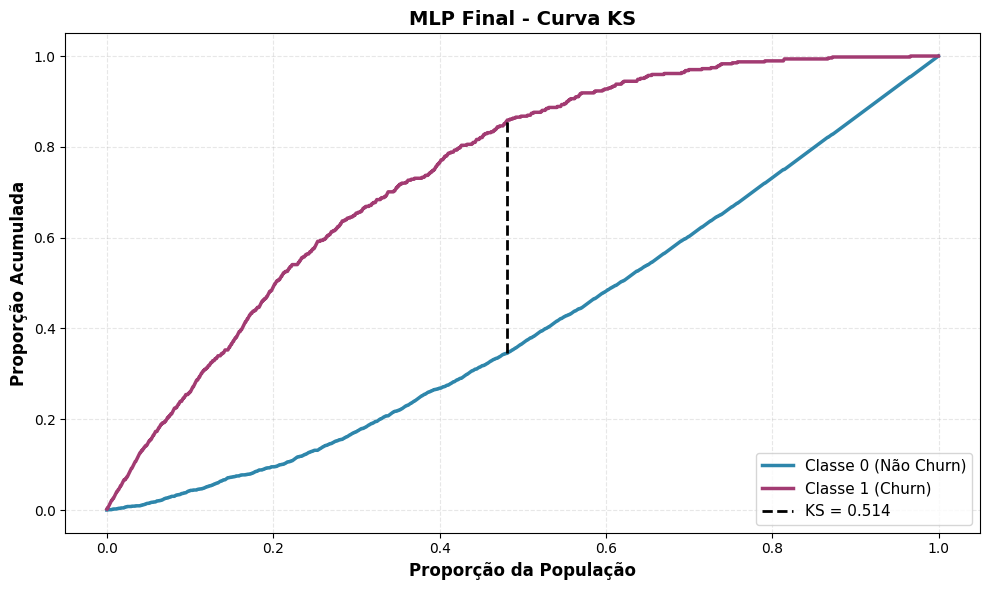

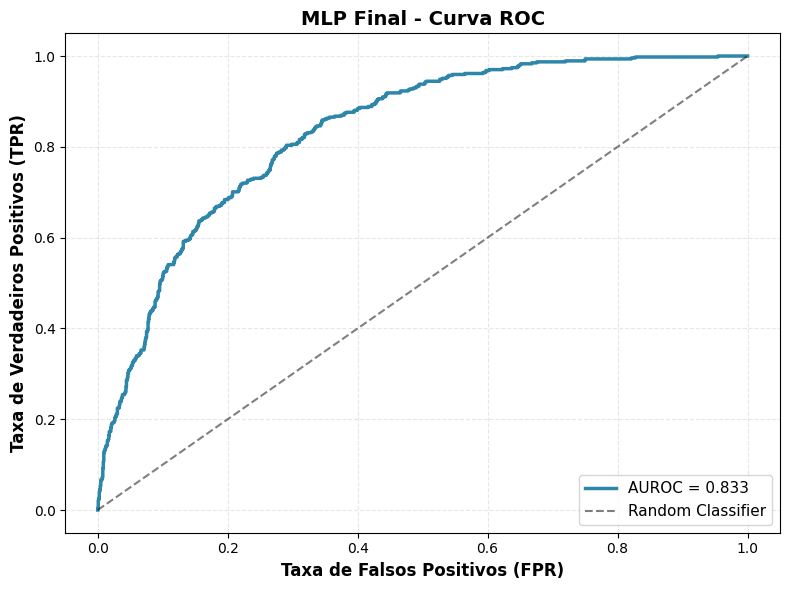


💾 Modelo salvo em 'models/mlp_best_model.pkl'


In [11]:
# ==========================================
# 6. Treinamento e Avaliação do Melhor Modelo (OPTUNA)
# ==========================================
import joblib

# 1. Recuperar e formatar os melhores parâmetros do estudo
best_params = study.best_params.copy()

print(f"🏆 Melhores parâmetros brutos: {best_params}")

# O Optuna salvou os neurônios como 'n_units_l0', 'n_units_l1'.
# Precisamos converter isso para a tupla 'hidden_layer_sizes' que o sklearn aceita.
n_layers = best_params.pop('n_layers')
layers_list = []
for i in range(n_layers):
    key = f'n_units_l{i}'
    layers_list.append(best_params.pop(key))

# Adiciona a tupla formatada de volta aos parâmetros
best_params['hidden_layer_sizes'] = tuple(layers_list)

print(f"⚙️ Configuração final para o modelo: {best_params}")

# 2. Instanciar o modelo final com essas configurações
final_model = MLPModel(name="MLP_Best_Optuna")

final_model.build(
    max_iter=10000,        # Fixo conforme Slide 27
    early_stopping=True,   # Fixo conforme Slide 24
    n_iter_no_change=20,   # Fixo conforme Slide 24
    **best_params          # Injeta: activation, solver, alpha, learning_rate, hidden_layer_sizes
)

# 3. Treinar
print("🚀 Treinando modelo final...")
final_model.train(X_train, y_train, X_val, y_val)

# 4. Avaliar no conjunto de TESTE (nunca visto pelo Optuna)
# O Slide 9 diz: "Nenhuma informação do conjunto de teste pode interferir"
y_pred_test = final_model.predict_proba(X_test)[:, 1]
metrics_test = calculate_all_metrics(y_test, y_pred_test)

print("\n📊 RESULTADOS NO TESTE:")
print_metrics("Melhor MLP", metrics_test)

# 5. Gerar Gráficos Obrigatórios (Slides 16 e 21)
plot_ks_statistic(y_test, y_pred_test, title="MLP Final - Curva KS")
plot_roc_curve(y_test, y_pred_test, title="MLP Final - Curva ROC")

# 6. Salvar o modelo (opcional, mas recomendado)
final_model.save("models/mlp_best_model.pkl")
print("\n💾 Modelo salvo em 'models/mlp_best_model.pkl'")

**Usando Grid Search (Manual)**

In [10]:
from sklearn.model_selection import ParameterGrid

# 1. Definir o Grid de Parâmetros (Slide 27)
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (10, 10), (50, 50)], # 1 e 2 camadas
    'activation': ['relu', 'tanh'], # Testando as principais
    'solver': ['adam'],             # Adam geralmente é melhor, mas pode adicionar 'sgd'
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]
}

grid = list(ParameterGrid(param_grid))
print(f"Total de combinações a testar: {len(grid)}")

best_score = float('inf')
best_params = None
best_model = None

# 2. Loop de Treinamento
for i, params in enumerate(grid):
    print(f"Testando combinação {i+1}/{len(grid)}: {params}")

    model = MLPModel(name=f"Grid_{i}")

    # Configuração estática obrigatória
    model.build(
        max_iter=10000,
        early_stopping=True,
        n_iter_no_change=20,
        **params
    )

    history = model.train(X_train, y_train, X_val, y_val)
    val_loss = history['val_logloss']

    if val_loss < best_score:
        best_score = val_loss
        best_params = params
        best_model = model # Guardamos o objeto do melhor modelo
        print(f"  -> Novo melhor encontrado! Val Loss: {val_loss:.4f}")

print("\n🏆 Melhor Resultado do Grid Search:")
print(best_params)

Total de combinações a testar: 32
Testando combinação 1/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
  -> Novo melhor encontrado! Val Loss: 0.4887
Testando combinação 2/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Testando combinação 3/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}
  -> Novo melhor encontrado! Val Loss: 0.4851
Testando combinação 4/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Testando combinação 5/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}
Testando combinação 6/32: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.01, 'solver': 'adam'}
Testando combinação

Treinar e Avaliar o Modelo Via Grid Search

🏆 Configuração Final Escolhida: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.001, 'alpha': 0.001}
🚀 Treinando modelo campeão...

📊 RESULTADOS FINAIS (CONJUNTO DE TESTE):
--- MLP Champion ---
KS:        0.5154 (Threshold: 0.44)
AUROC:     0.8323
F1 Score:  0.6103


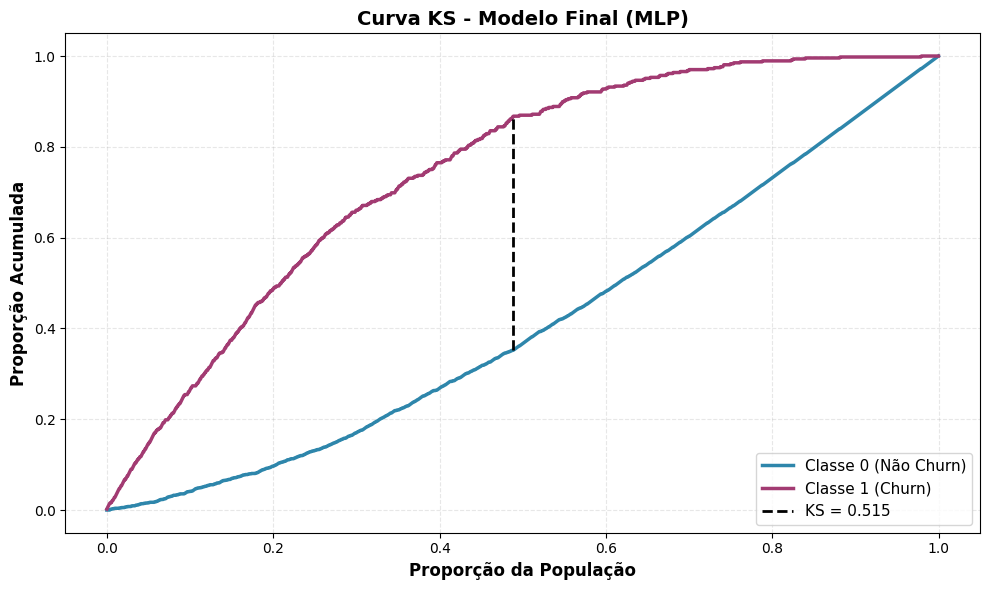

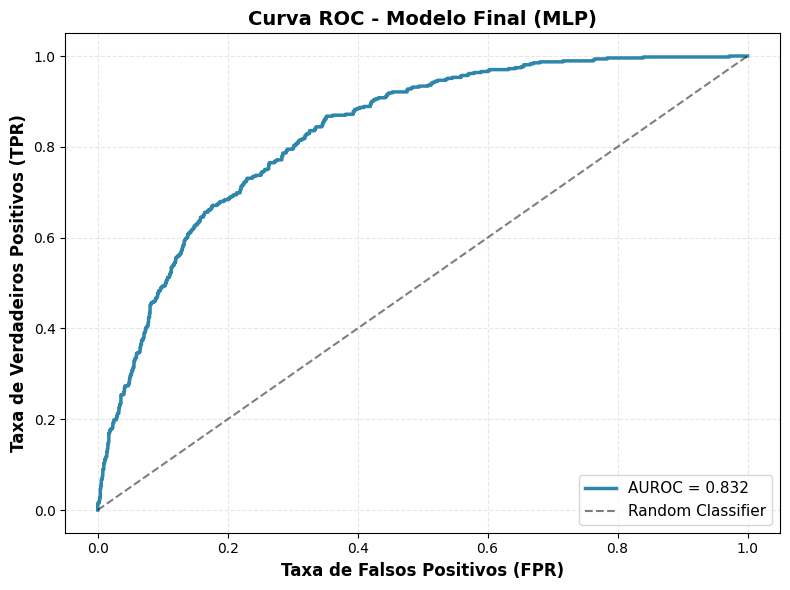


💾 Modelo salvo em 'models/mlp_final_champion.pkl'


In [12]:
# ==========================================
# 6. Treinamento do Modelo Campeão (Via Grid Search)
# ==========================================
import joblib

# Parâmetros vencedores do Grid Search (Combinação 27/32)
best_params_grid = {
    'hidden_layer_sizes': (50,),    # Mais simples que o Optuna (Navalha de Occam - Slide 24)
    'activation': 'tanh',           # Validado por ambos os testes
    'solver': 'adam',
    'learning_rate_init': 0.001,
    'alpha': 0.001
}

print(f"🏆 Configuração Final Escolhida: {best_params_grid}")

# Instanciar modelo final
final_model = MLPModel(name="MLP_Final_Champion")
final_model.build(
    max_iter=10000,       # Slide 24
    early_stopping=True,  # Slide 24
    n_iter_no_change=20,  # Slide 24
    **best_params_grid
)

# Treinar
print("🚀 Treinando modelo campeão...")
final_model.train(X_train, y_train, X_val, y_val)

# Avaliação Final no Teste
y_pred_test = final_model.predict_proba(X_test)[:, 1]
metrics_test = calculate_all_metrics(y_test, y_pred_test)

print("\n📊 RESULTADOS FINAIS (CONJUNTO DE TESTE):")
print_metrics("MLP Champion", metrics_test)

# Gráficos Obrigatórios
plot_ks_statistic(y_test, y_pred_test, title="Curva KS - Modelo Final (MLP)")
plot_roc_curve(y_test, y_pred_test, title="Curva ROC - Modelo Final (MLP)")

# Salvar
final_model.save("models/mlp_final_champion_Grid_Search.pkl")
print("\n💾 Modelo salvo em 'models/mlp_final_champion.pkl'")